In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import m2cgen as m2c

In [2]:
# 1. Load data
df = pd.read_csv("data_sensor_2.csv", delimiter=";")

In [3]:
# 2. Handle missing values (isi dengan mean)
df.fillna(df.mean(numeric_only=True), inplace=True)

In [4]:
# 3. Pisahkan fitur dan label
X = df[['BPM', 'BodyTemperature', 'AmbientTemperature']]
y = df['Fatigue']

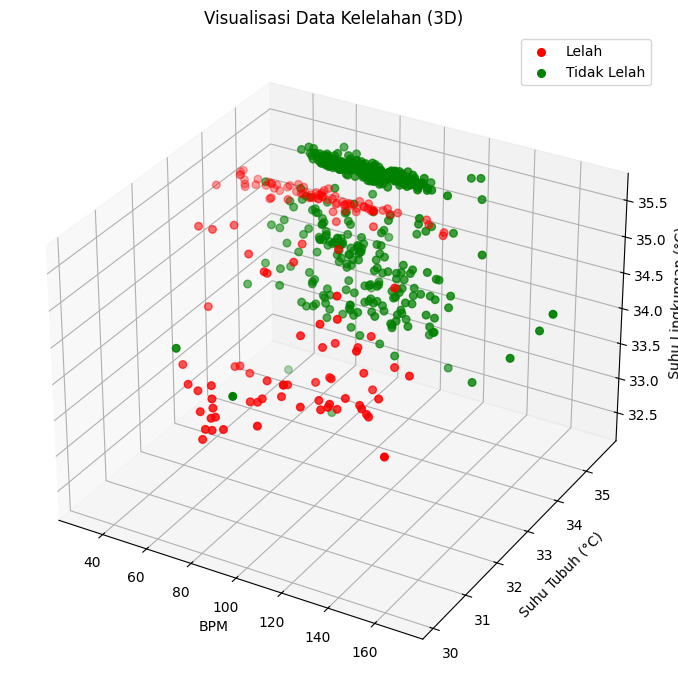

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Pisahkan berdasarkan kelas
X_fatigue = X[y == 1]
X_not_fatigue = X[y == 0]

# Plotting
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Titik-titik LELAH (1) → merah
ax.scatter(X_fatigue['BPM'], X_fatigue['BodyTemperature'], X_fatigue['AmbientTemperature'],
           c='red', label='Lelah', s=30, marker='o')

# Titik-titik TIDAK LELAH (0) → hijau
ax.scatter(X_not_fatigue['BPM'], X_not_fatigue['BodyTemperature'], X_not_fatigue['AmbientTemperature'],
           c='green', label='Tidak Lelah', s=30, marker='o')

# Label dan tampilan
ax.set_xlabel('BPM')
ax.set_ylabel('Suhu Tubuh (°C)')
ax.set_zlabel('Suhu Lingkungan (°C)')
ax.set_title('Visualisasi Data Kelelahan (3D)')
ax.legend()

plt.tight_layout()
plt.show()


In [6]:
# 4. Normalisasi (Min-Max Scaling)
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
print(X.describe())

              BPM  BodyTemperature  AmbientTemperature
count  618.000000       618.000000          618.000000
mean    83.378641        34.362330           34.959191
std     20.736262         1.098764            0.641675
min     30.000000        30.090000           32.330000
25%     70.000000        34.375000           34.430000
50%     82.000000        34.830000           35.270000
75%     95.750000        34.950000           35.500000
max    170.000000        35.650000           35.630000


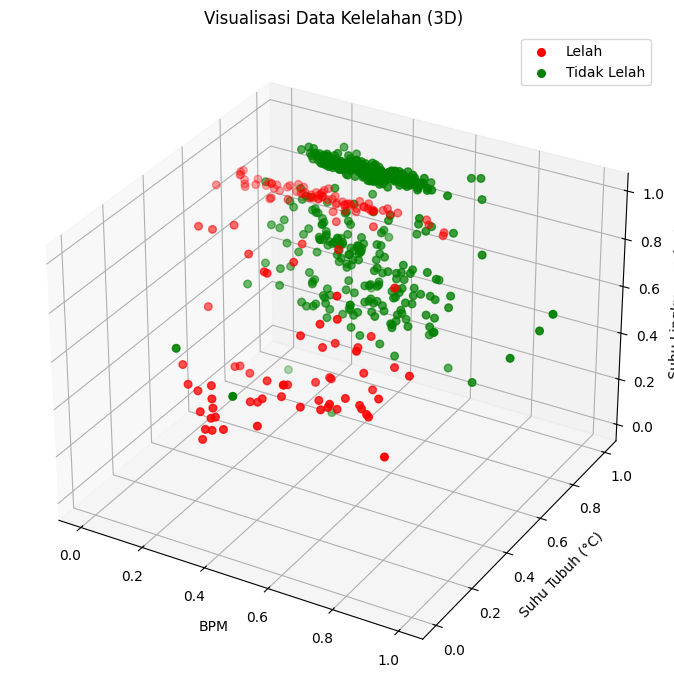

In [7]:
X_fatigue = X_scaled[y == 1]
X_not_fatigue = X_scaled[y == 0]

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_fatigue[:, 0], X_fatigue[:, 1], X_fatigue[:, 2],
           c='red', label='Lelah', s=30, marker='o')
ax.scatter(X_not_fatigue[:, 0], X_not_fatigue[:, 1], X_not_fatigue[:, 2],
           c='green', label='Tidak Lelah', s=30, marker='o')

# Label dan tampilan
ax.set_xlabel('BPM')
ax.set_ylabel('Suhu Tubuh (°C)')
ax.set_zlabel('Suhu Lingkungan (°C)')
ax.set_title('Visualisasi Data Kelelahan (3D)')
ax.legend()

plt.tight_layout()
plt.show()


In [8]:
# 5. Split data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42, stratify=y)

In [9]:
# 6. Train SVM (linear agar bisa dikonversi ke TinyML)
model = SVC(kernel='linear')
model.fit(X_train, y_train)

SVC(kernel='linear')

In [10]:
# 7. Evaluasi
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy: 0.9112903225806451
              precision    recall  f1-score   support

           0       0.90      1.00      0.95        96
           1       1.00      0.61      0.76        28

    accuracy                           0.91       124
   macro avg       0.95      0.80      0.85       124
weighted avg       0.92      0.91      0.90       124



In [11]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

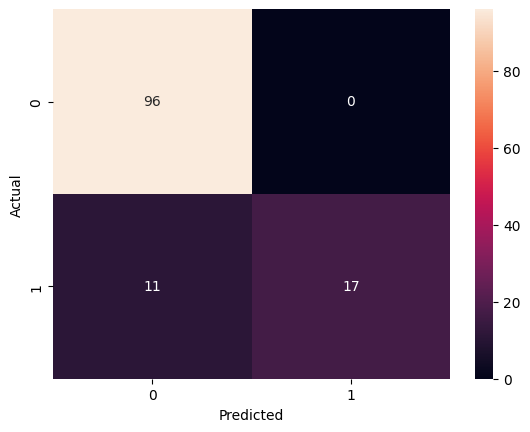

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


## GridSearch

In [13]:
param_grid = {
    'C': [0.1, 1, 10, 100], 
    'kernel': ['linear'],  # Tetap linear karena targetnya TinyML
}

In [14]:
grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'kernel': ['linear']},
             scoring='accuracy')

In [15]:
model = grid_search.best_estimator_
y_pred_best = model.predict(X_test)
print("=== Optimized Linear SVM (Grid Search) ===")
print("Best Parameters:", grid_search.best_params_)
print("Accuracy:", accuracy_score(y_test, y_pred_best))
print(classification_report(y_test, y_pred_best))

=== Optimized Linear SVM (Grid Search) ===
Best Parameters: {'C': 100, 'kernel': 'linear'}
Accuracy: 1.0
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        96
           1       1.00      1.00      1.00        28

    accuracy                           1.00       124
   macro avg       1.00      1.00      1.00       124
weighted avg       1.00      1.00      1.00       124



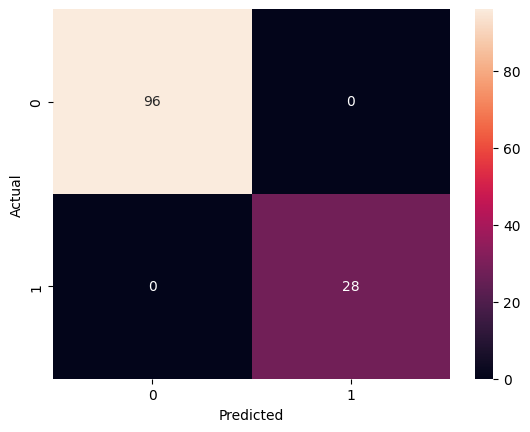

In [16]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred_best)
import matplotlib.pyplot as plt
import seaborn as sns
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [17]:
# 8. Konversi model ke kode C untuk ESP32 (TinyML)
c_code = m2c.export_to_c(model)

In [18]:
# Simpan sebagai file .c
with open("svm_model_fatigue.c", "w") as f:
    f.write(c_code)

In [19]:
# Simpan juga scaler (opsional jika digunakan di sisi ESP)
import joblib
joblib.dump(scaler, "scaler_fatigue.save")

['scaler_fatigue.save']

## Manual Test

In [26]:
import pandas as pd

import numpy as np

inputdata = [90.4,33.83,29.57] # BPM, Body,Ambient

#metode 1
input_manual = np.array([inputdata])  # BPM, BodyTemp, AmbientTemp
input_manual_scaled = scaler.transform(input_manual)
y_pred_manual = model.predict(input_manual_scaled)

print("Prediksi1:", y_pred_manual[0])

#metode 2
feature_names = ['BPM', 'BodyTemperature', 'AmbientTemperature']

input_data = pd.DataFrame([inputdata], columns=feature_names)
input_scaled = scaler.transform(input_data)
prediksi = model.predict(input_scaled)

print("Prediksi2:", y_pred_manual[0])

Prediksi1: 0
Prediksi2: 0


C:\Users\acer\AppData\Roaming\Python\Python311\site-packages\sklearn\base.py:465: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(
